# Vehicle Detection and Tracking
---
> Daniel Stang
    

## Extract Features From Image

### Histogram of Gradient

In [6]:
# Import
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import StandardScaler

print('Import successful.')

Import successful.


In [7]:
# Histogram of Oriented Gradients
def hog_features(img, cspace='gry', chan=0, orientbin=9, cellpix=8, cellb=2, visual=False, vector=True):
    
    # Pick feature and channel to perform HOG on.
    if cspace == 'rgb':
        newimg = img[:,:,chan]
    if cspace == 'gry':
        newimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if cspace == 'hsv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'luv':
        tmpimg =  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'hls':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        newimg = tmpimg[:,:,chan]
    if cspace == 'yuv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        newimg = tmpimg[:,:,chan]    
    
    if visual == True:
        features, visual_image = hog(newimg, orientations=orientbin,
                                     pixels_per_cell=(cellpix, cellpix),
                                     cells_per_block=(cellb, cellb),
                                     transform_sqrt=True,
                                     visualise=True, feature_vector=True)
        return features, visual_image
    else:
        features = hog(newimg, orientations=orientbin,
                       pixels_per_cell=(cellpix, cellpix),
                       cells_per_block=(cellb, cellb),
                       transform_sqrt=True,
                       visualise=False, feature_vector=True)
        return features
        
    

In [8]:
def color_hist(img, nbins=32, bins_range=(0,1)):
    # Calculate the histogram for each color channel.
    chan1hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    chan2hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    chan3hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms in one feature.
    histfeat = np.concatenate((chan1hist[0], chan2hist[0], chan3hist[0]))
    return histfeat/1000


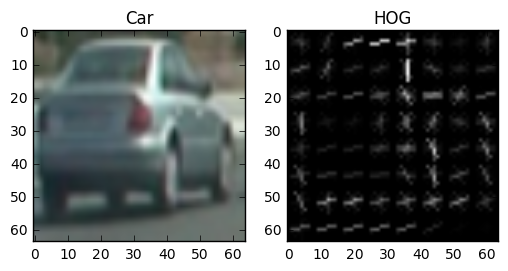

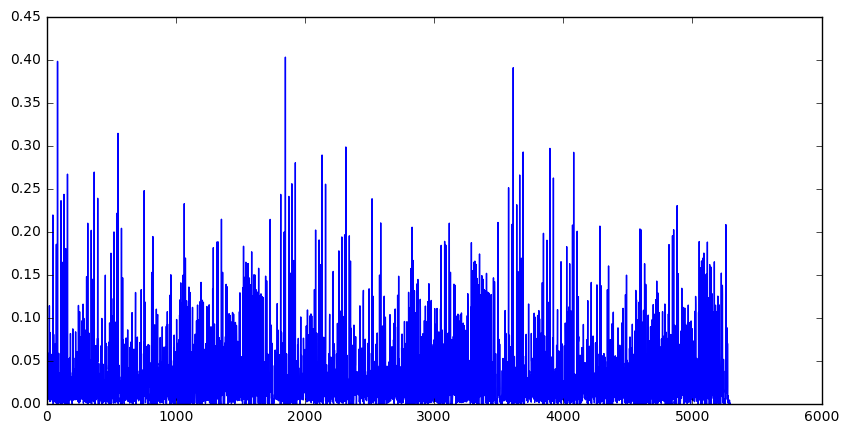

/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


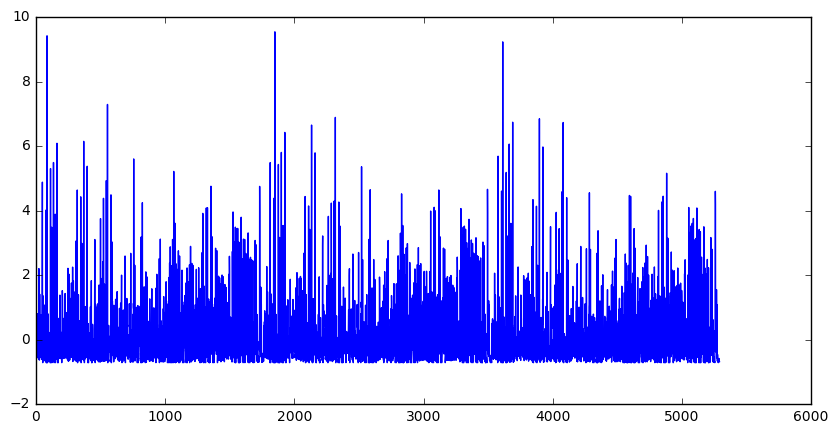

In [9]:
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
#img = mpimg.imread('img/non-vehicles/GTI/image1.png')



orientbin = 9
cellpix = 8
cellb = 2

features, visual_image = hog_features(img, 'yuv', 0, orientbin, cellpix, cellb, True)
colorh = color_hist(img)
features2 = np.append(features, hog_features(img, 'hsv', 2))
features3 = np.append(features2, hog_features(img, 'hls', 1))




fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Car')
plt.subplot(122)
plt.imshow(visual_image, cmap='gray')
plt.title('HOG')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.plot(features3)
plt.show()

x_scaler = StandardScaler().fit(features3)
scaledx = x_scaler.transform(features3)

fig = plt.figure(figsize=(10,5))
plt.plot(scaledx)
plt.show()



## Train Classifier

### Label Data


In [10]:
imagename = sorted(glob.glob('img/non-vehicles/Extras/*.png'))
imagename2 = sorted(glob.glob('img/non-vehicles/GTI/*.png'))
imagename = imagename + imagename2
notcarlen = len(imagename)
print(notcarlen)
foldername = sorted(glob.glob('img/vehicles/*'))
for fold in foldername:
    imagename2 = sorted(glob.glob(fold + '/*.png'))
    imagename = imagename + imagename2

print(imagename[notcarlen-1])
print(imagename[notcarlen])
print(len(imagename))


9666
img/non-vehicles/GTI/image999.png
img/vehicles/GTI_Far/image0000.png
18458


In [11]:
# Load all images and extract features.
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
feat1 = hog_features(img, 'yuv', 0)
feat2 = np.append(feat1, hog_features(img, 'hsv', 2))
testfeat = np.append(feat2, hog_features(img, 'hls', 1))

xdata = np.zeros((18458,len(feat2))).astype('float32')
i=0
for imgn in tqdm(imagename):
    imgd = mpimg.imread(imgn)
    feat1 = hog_features(imgd, 'yuv', 0)
    feat2 = np.append(feat1, hog_features(imgd, 'hsv', 2))
    xdata[i] = feat2
    i = i + 1

    

100%|██████████| 18458/18458 [00:49<00:00, 374.75it/s]


In [12]:
# Ensure that non vehicles labeled with 0 and vehicles labeled with 1.
y = np.zeros(18458).astype(int)
y[9666:] = 1

print(str(imagename[9665]) + ' ' + str(y[9665]))
print(str(imagename[9666]) + ' ' + str(y[9666]))
print(str(imagename[1337]) + ' ' + str(y[1337]))
print(str(imagename[13337]) + ' ' + str(y[13337]))

img/non-vehicles/GTI/image999.png 0
img/vehicles/GTI_Far/image0000.png 1
img/non-vehicles/Extras/extra2201.png 0
img/vehicles/KITTI_extracted/1760.png 1


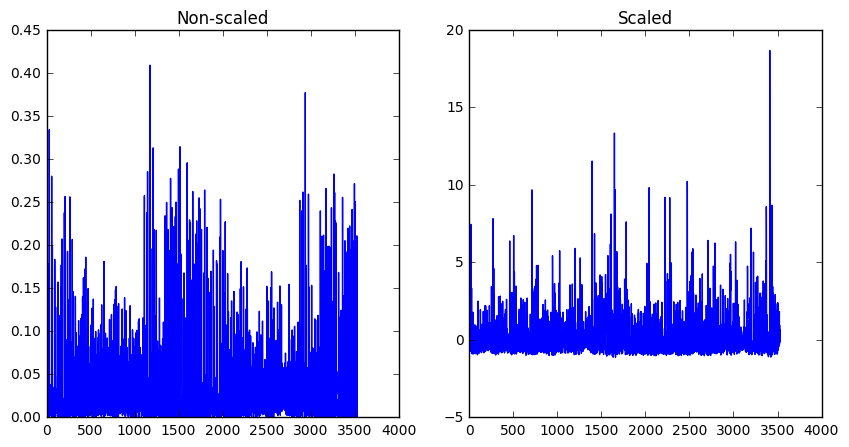

14766
14766
3692
3692


/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


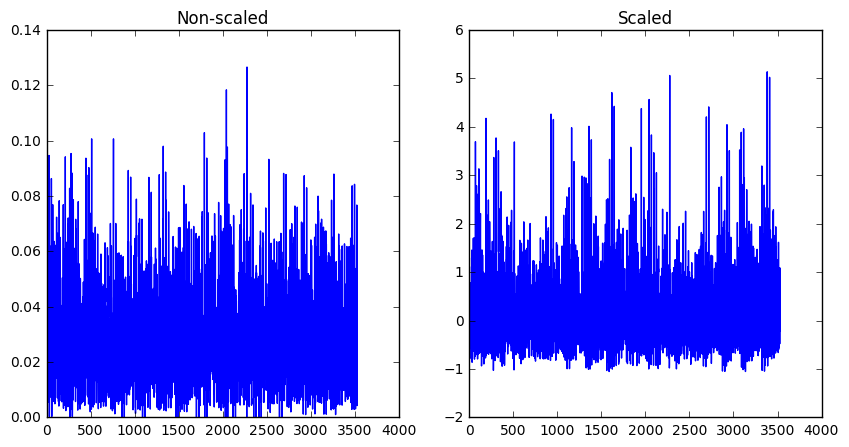

In [13]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(xdata[15000])
plt.title('Non-scaled')

X_scaler = StandardScaler().fit(xdata)
scaledx = X_scaler.transform(xdata)

plt.subplot(122)
plt.plot(scaledx[0])
plt.title('Scaled')
plt.show()

x_train, x_test, y_train, y_test = train_test_split(xdata, y, test_size=0.2, random_state=1337)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(xdata[2])
plt.title('Non-scaled')

scaledx2 = X_scaler.transform(xdata[2])

plt.subplot(122)
plt.plot(scaledx2)
plt.title('Scaled')
plt.show()

### SVC

In [14]:
linsvc = svm.LinearSVC(loss='squared_hinge',tol=1e-4, max_iter=3000)
t = time.time()
linsvc.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', linsvc.score(x_train, y_train))
print('Test Accuracy', linsvc.score(x_test, y_test))


Training time: 9.833561182022095 seconds
Train Accuracy 0.988622511174
Test Accuracy 0.966955579632


    Just HOG
    HLS [0, .933], [1, .959], [2, .905]
    HSV [0, .933], [1, .910], [2, .954]
    YUV [0, .963], [1, .947], [2, .xxx]
    RGB [0, .950], [1, .960], [2, .956]
    
    With Color Hist
    YUV [0, 0.954]
    
    hsv2 + yuv0 - nonscaled - 0.967
                - scaled - 0.955
    hsv2 + yuv + hls1 - nonscaled - 0.967
                      - scaled - 0.957
                      
Scaling train accuracy jumps but test accuracy doesn't.

In [15]:
# svc = svm.SVC(kernel='linear')
# t = time.time()
# svc.fit(x_train, y_train)
# t2 = time.time()

# print('Training time:', t2-t, 'seconds')
# print('Train Accuracy', svc.score(x_train, y_train))
# print('Test Accuracy', svc.score(x_test, y_test))


# Stats using rbf kernel.
# 1.9 seconds to fit 922 samples.
# 121 seconds to fit 9229 samples.
# Takes waaaay to long when using rbf on so many samples
# and linear SVC seems to do just fine accuracy wise.

### Decision Tree

In [16]:
dtree = tree.DecisionTreeClassifier(min_samples_split=20, max_depth=8)
t = time.time()
dtree = dtree.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', dtree.score(x_train, y_train))
print('Test Accuracy', dtree.score(x_test, y_test))
    

Training time: 37.03350257873535 seconds
Train Accuracy 0.953406474333
Test Accuracy 0.879469122427


## Sliding Window Search


In [49]:
def debug_img():
    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test6.jpg')
    windows = slide_window(img,0.5)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
        
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Car')

    windows = slide_window(img, 0)
    imgbox = draw_boxes(img, windows)

    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('Window')
    plt.tight_layout()
    plt.show()

    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test3.jpg')
    windows = slide_window(img,0.5)
    imgbox = draw_boxes(img, windows)

    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Car')

    windows = slide_window(img, 0)
    imgbox = draw_boxes(img, windows)

    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('Window')
    plt.tight_layout()
    plt.show()

150


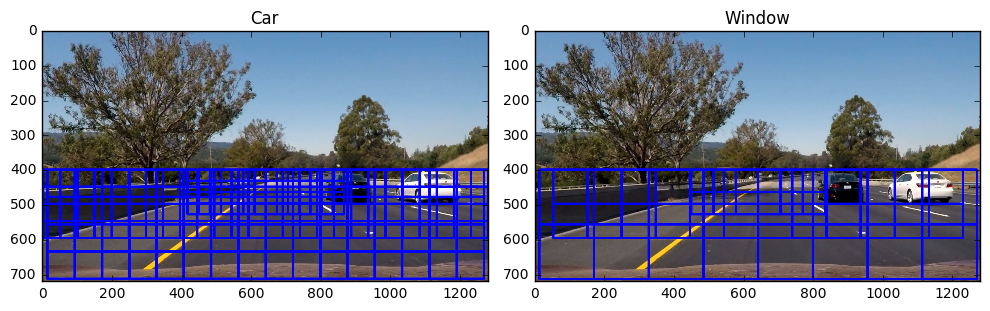

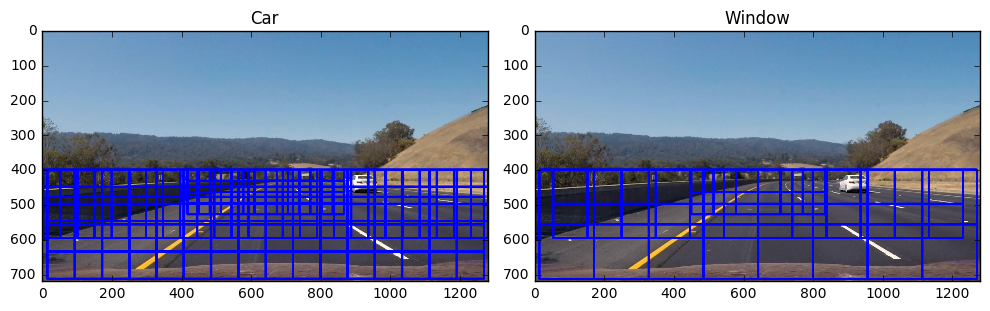

In [50]:
# Draw boxes on new image.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Crop window area of image 
def crop_resize(img, window):
    
    crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    resize = cv2.resize(crop, (64, 64))
    
    return resize

# Return x and y coordinates for all computed window search positions.
def slide_window(img, xy_overlap = 0.5, xy_window = 64, y_start_stop=[400, None]):
    
    
    xcenter = np.int(img.shape[1]/2)
    
    # If y start/stop positions not defined, set to image size.    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Initialize a list to append window positions to.
    window_list = []

    
    starty = y_start_stop[0]
    ny_window = 3
    growth = 1.104
    
    for yi in range(0,ny_window):
        step = np.int(xy_window *(1 - xy_overlap))
        endy = starty + xy_window
        nx_window = np.int(img.shape[1]/(step*2))
        if yi == 0:
            nx_window = nx_window - 7*np.int(xy_window/step)
            # How many xy_window tall pixels should be covered in the y direction.
            ystack = 2
        if yi == 1:
            nx_window = nx_window - 0*np.int(xy_window/step)
            ystack = 2
        if yi == 2:
            ystack = 2
            nx_window = nx_window - 0*np.int(xy_window/step)
        
        # Ensures that both overlap and non-overlap cases cover the same number of pixels
        # in the y direction. Ex smallest boxes want to cover 2 * 64 pixels. With non-overlap
        # thats two sets of 64 pixel tall windows stacked on top of eachother. For 50% overlap 
        # that requires 3 sets of 64 pixels tall windows with 50% overlap.
        if xy_overlap != 0:
            ystack =  np.int(ystack*(xy_window/step)) - 1
            
        for yii in range(ystack):
            for xi in range(nx_window):
                startx = xcenter + xi*step
                endx = startx + xy_window
                # Only add to list if within image bounds.
                if endx < img.shape[1]:
                    window_list.append( ((startx, starty), (endx, endy)) )

                endx = xcenter - xi*step
                startx = endx - xy_window
                # Only add to list if within image bounds.
                if startx > 0:
                    window_list.append( ((startx, starty), (endx, endy)) )
            
            starty = starty + step
            endy = starty + xy_window
            
        starty = y_start_stop[0]
        xy_window = np.int(xy_window **growth)
        
        
    
    # Return the list of window positions.
    return window_list

debug_img()

/home/daniel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[[ 836  400  934  498]
 [ 983  400 1081  498]
 [1081  400 1179  498]
 [1130  449 1228  547]
 [ 796  400  953  557]]


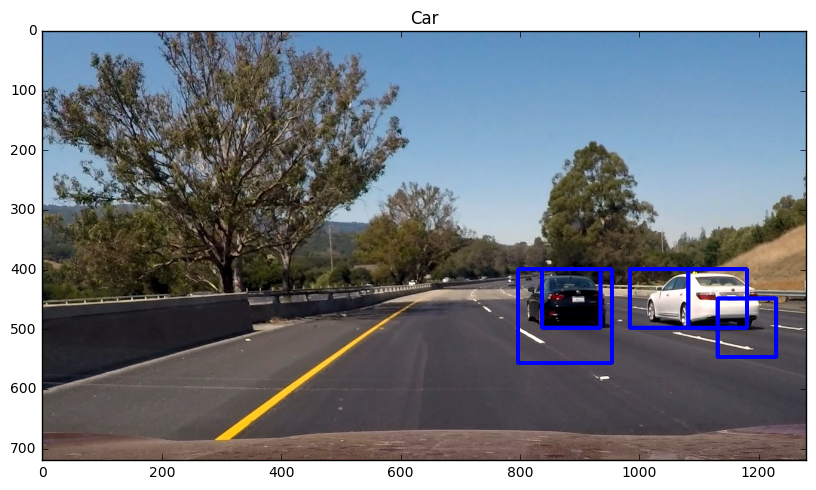

In [122]:
img = mpimg.imread('CarND-Vehicle-Detection/test_images/test6.jpg')
img2 = mpimg.imread('CarND-Vehicle-Detection/test_images/test6.jpg')
windows = slide_window(img,0.5)

b = None
for i in range(len(windows)):
    newimg = crop_resize(img, windows[i])
    #a = linsvc.predict(hog_features(newimg, 'yuv', 0).reshape(1, -1))
    feat = np.append(hog_features(newimg, 'yuv', 0), hog_features(newimg, 'hsv', 2))
    #feat2 = np.append(feat, hog_features(newimg, 'hls', 1))
    #c = x_scaler.transform(d)
    a = linsvc.predict(feat.reshape(1,-1))
    if a == 1:
        if b == None:
            temp = np.hstack(windows[i])
            b = temp
            img2 = draw_boxes(img2, windows[i:i+1])
        else:
            temp = np.hstack(windows[i])
            img2 = draw_boxes(img2, windows[i:i+1])
            b = np.vstack((b, temp)).astype(int)

print(b)



fig = plt.figure(figsize=(10,5))
plt.imshow(img2)
plt.title('Car')
plt.tight_layout()
plt.show()

### Combining Multiple Boxes

In [170]:
def combine_pred(pred_windows):
    # Find overlaping or touching windows and group them.
    
    # Return what was input if there are 0 or 1 prediction windows.
    if len(pred_windows) < 2:
        return pred_windows
    
    prednum = np.zeros( (len(pred_windows),len(pred_windows)) )
    
    # Calculate centroids of each window.
    cent = []
    for window in pred_windows:
        xcent = np.int((window[0] + window [2])/2)
        ycent = np.int((window[1] + window[3])/2)
        
        cent.append((xcent, ycent))
    
    print(cent)
    print(len(cent))
    # Classify windows as a group if distance to another centroid is within set number
    # of pixels in x or y direction.
    for i in range(len(cent)):
        group = i+1
        
        # If this window already has an existing match
        # set its group number to that number.
        temppred = prednum[:,i]
        if len(temppred[temppred > 0]) > 0:
            group = temppred[temppred >0][0]
            
        for j in range(len(cent)):
            if i == j:
                continue
                
            # Compare x distance.
            if (abs(cent[i][0] - cent[j][0]) <= 110):
                # Compare y distance.
                if (abs(cent[i][1] - cent[j][1]) <= 110):
                    # If a match is found, check if the match is already assigned
                    # a group number.
                    temppred = prednum[:,j]
                    if len(temppred[temppred > 0]) > 0:
                        group = temppred[temppred > 0][0]
                    
                    # Assign the
                    prednum[i,j] = group
                    
    
    
    predgroup = np.zeros(len(cent))
    for i in range(len(cent)):
        predgroup[i] = max(prednum[i,:])
    
    return predgroup

print(b)
# c = np.copy(b)
# c[0] = b[3]
# c[3] = b[0]

# print('\n')
# print([1, 0, 1, 1,0])
# print(c)
print(combine_pred(b))

        
            
        

        
    
    
    
    

[[ 836  400  934  498]
 [ 983  400 1081  498]
 [1081  400 1179  498]
 [1130  449 1228  547]
 [ 796  400  953  557]]
[(885, 449), (1032, 449), (1130, 449), (1179, 498), (874, 478)]
5
[ 1.  2.  2.  2.  1.]


In [168]:
x = np.zeros(5)
x[1] = 10

for i in range(4):
    if i == 2:
        continue
    if (abs(5 - 10) <= 5):
        print('nope.')
    print(i)

nope.
0
nope.
1
nope.
3


In [116]:
y = np.array(((1, 2, 0, 0, 0),(0, 0, 0, 0, 0)))
print(y)
print(y[:,1])
x = y[:,1]
print(len(x[x>0]))
print(x[x>0][0])


[[1 2 0 0 0]
 [0 0 0 0 0]]
[2 0]
1
[2]


In [148]:
x = np.array([1,3])
y = np.array([3,1])
z = np.vstack((x,y))
z = np.vstack((z,[3,2]))
z = np.vstack((z,[2,3]))
z = np.vstack((z,[4,5]))
z = np.vstack((z,[5,4]))
print(z)
print('\n')

print(z[z==4])

[[1 3]
 [3 1]
 [3 2]
 [2 3]
 [4 5]
 [5 4]]


[4 4]
